# **Deep Learning Lab: MNIST with Keras**

__author__:Sehyun Park  
__email__:ps_hyen@snu.ac.kr

In this notebook, we construct a simple convolutional neural network with Keras.

In [1]:
import tensorflow as tf
tf.random.set_seed(10)

In [2]:
class TFModule(tf.Module):
  def __init__(self, D_x, D_h1, name = None):
    super().__init__(name=name)
    self.w1 = tf.Variable(tf.random.normal((D_x, D_h1)), name='w1')
    self.w2 = tf.Variable(tf.random.normal((D_h1, 1)), name='w2')
  def __call__(self, x):
    h1 = tf.maximum(tf.matmul(x, self.w1), 0)
    return tf.matmul(h1, self.w2)

def loss(target_y, pred_y):
  return tf.reduce_mean(tf.square(target_y - pred_y))


In [3]:
batch_size, D_x, D_h1 = 10000, 10, 32
learning_rate = 0.01

mymodel = TFModule(D_x, D_h1)

x = tf.random.normal((batch_size, D_x))
y = tf.random.normal((batch_size, 1))
for i in range(5):
  with tf.GradientTape() as t:
    current_loss = loss(y, mymodel(x))

  print(current_loss)

  grad_w1, grad_w2 = t.gradient(current_loss, [mymodel.w1, mymodel.w2])

  mymodel.w1.assign_sub(learning_rate * grad_w1)
  mymodel.w2.assign_sub(learning_rate * grad_w2)

tf.Tensor(133.3339, shape=(), dtype=float32)
tf.Tensor(49.15583, shape=(), dtype=float32)
tf.Tensor(29.986074, shape=(), dtype=float32)
tf.Tensor(22.228027, shape=(), dtype=float32)
tf.Tensor(18.097588, shape=(), dtype=float32)


### Using Keras Module

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input

In [5]:
N, D_x, D_h1 = 10000, 10, 32
learning_rate = 0.01

model = keras.Sequential(
    [
        Input(shape=(D_x,)),
        layers.Dense(D_h1, activation = "relu", use_bias = False, name = "w1"),
        layers.Dense(1, use_bias = False, name = "w2")
    ]
)

# Equivalent with:

# model = keras.Sequential()
# model.add(Input(shape=(D_x,)))
# model.add(layers.Dense(D_h1, activation = "relu", use_bias = False, name = "w1"))
# model.add(layers.Dense(1, use_bias = False, name = "w2"))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ w1 (Dense)                           │ (None, 32)                  │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ w2 (Dense)                           │ (None, 1)                   │              32 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 352 (1.38 KB)

 Trainable params: 352 (1.38 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
model.compile(optimizer = "sgd", loss = 'mse', metrics = ['mse']) # default learning rate for 'sgd' is 0.01

x = tf.random.normal((N, D_x))
y = tf.random.normal((N, 1))

hist = model.fit(x, y, epochs = 5, steps_per_epoch = 1)

Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 1.7290 - mse: 1.7290
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0000e+00 - mse: 0.0000e+00
Epoch 3/5


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 1.6937 - mse: 1.6937
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0000e+00 - mse: 0.0000e+00
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 1.6608 - mse: 1.6608


In [8]:
# save whole model
# model.save("test.h5")
model.save("test.keras")

# load the trained model
# loaded_model = keras.models.load_model("test.h5")
loaded_model = keras.models.load_model("test.keras")

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 4 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Digit Classification with Convolutional Neural Network

__reference__ = https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py

Trains a simple convnet on the MNIST dataset.
Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.

In [9]:
import numpy as np
import tensorflow as tf
import keras
from keras.datasets import mnist # load mnist dataset
from keras.models import Sequential # construct computational grpah
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

print('Check GPU availability')
print(tf.config.list_physical_devices('GPU'))

Check GPU availability
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Set hyper-parameters and download MNIST

In [10]:
batch_size = 128
num_classes = 10 # from 0 to 9
epochs = 3 # The original epoch number was 12

# input image dimensions
img_rows, img_cols = 28, 28

In [11]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print('shape of (x_train, y_train) :', x_train.shape, y_train.shape)
print('shape of (x_test, y_test) :', x_test.shape, y_test.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
shape of (x_train, y_train) : (60000, 28, 28) (60000,)
shape of (x_test, y_test) : (10000, 28, 28) (10000,)


In [12]:
x_train = x_train.reshape((60000, 28, 28, 1))
x_test = x_test.reshape((10000, 28, 28, 1))
input_shape = (img_rows, img_cols, 1)

print('After reshaping (N, 28, 28) -> (N, 28, 28, 1)') # A gray-scale image has the only one channel.
print('shape of (x_train, y_train) :', x_train.shape, y_train.shape)
print('shape of (x_test, y_test) :', x_test.shape, y_test.shape)

After reshaping (N, 28, 28) -> (N, 28, 28, 1)
shape of (x_train, y_train) : (60000, 28, 28, 1) (60000,)
shape of (x_test, y_test) : (10000, 28, 28, 1) (10000,)


# Examples of MNIST

In [13]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

Text(0.5, 1.0, 'Example of the training image, class 5')

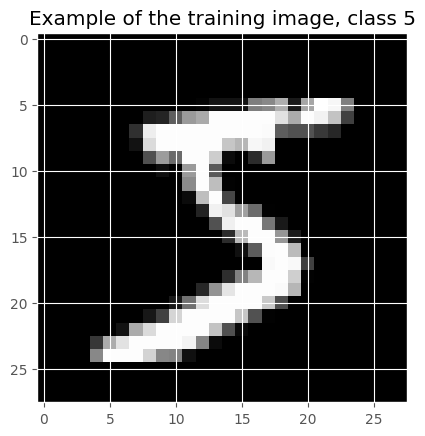

In [14]:
plt.imshow(x_train[0,:,:,0]/255, cmap = 'gray', vmin = 0, vmax = 1)
plt.title('Example of the training image, class {}'.format(y_train[0]))

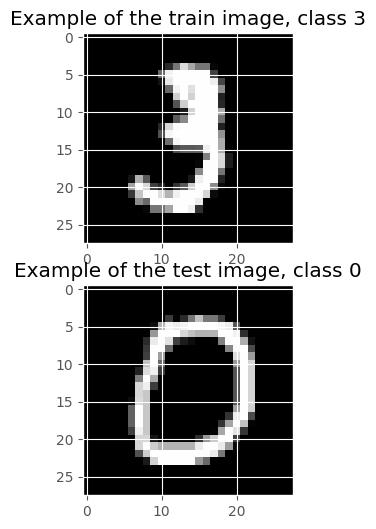

In [15]:
plt.figure(figsize=(8,6))
plt.subplot(2,1,1)
plt.imshow(x_train[10,:,:,0]/255, cmap = 'gray', vmin = 0, vmax = 1)
plt.title('Example of the train image, class {}'.format(y_train[10]))
plt.subplot(2,1,2)
plt.imshow(x_test[10,:,:,0]/255, cmap = 'gray', vmin = 0, vmax = 1)
plt.title('Example of the test image, class {}'.format(y_test[10]))
plt.show()

# Preprocess dataset

In [16]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255 # A range of intensity of raw data is [0, 255]
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print(y_train[0].shape, y_train[0])

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
(10,) [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [17]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu')) # number of channel, kernel_size
model.add(MaxPooling2D((2, 2))) # pool_size
model.add(Dropout(0.25)) # drop rate
model.add(Flatten())
model.add(Dense(128, activation='relu')) # output size
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy']) # When you use Keras, you need to complie the model!

In [19]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,179,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,199,882 (4.58 MB)

 Trainable params: 1,199,882 (4.58 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0) # print loss and accuracy

Epoch 1/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.0989 - loss: 2.3074 - val_accuracy: 0.1594 - val_loss: 2.2752
Epoch 2/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.1718 - loss: 2.2731 - val_accuracy: 0.3288 - val_loss: 2.2369
Epoch 3/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.2513 - loss: 2.2363 - val_accuracy: 0.4696 - val_loss: 2.1882


In [21]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 2.188220977783203
Test accuracy: 0.46959999203681946
